# Physics-Informed Neural Networks

# Objective
### To learn the pressure head field across a dam aquifer system.
### To Compute water velocity from the pressure gradient


# Assumptions

### 1. Incompressible flow (reasonable for water)

### 2. Steady-state conditions (no time dependence)

### 3. Isotropic porous medium (same hydraulic behavior in all directions)

### 4. Under these conditions, the governing equations reduce to Darcy flow and Laplace’s equation.

# PINN:

### Learns 2D steady-state groundwater head distribution.

### Uses physics (Laplace), boundary conditions, and normalized inputs.

### Trains with Adam + L-BFGS.

### Uses Fourier features

## 1 Imports and Device

In [1]:

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tkinter import filedialog, Tk
from pathlib import Path

# Setup: Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## 2 Load CSV Locally

In [3]:

root = Tk()
root.withdraw()  # Hide GUI root window
file_path = filedialog.askopenfilename(title="Select your CSV file")
data = pd.read_csv(file_path)

filename = Path(file_path).name
parts = filename.split('.')[0].split('_')
h1, h2 = float(parts[0]), float(parts[1])


## 3 Normalize and Embed Inputs

In [16]:

x_raw = data["X"].values.astype(np.float32)
y_raw = data["Y"].values.astype(np.float32)
h_raw = data["FINIT"].values.astype(np.float32)

x_min, x_max = x_raw.min(), x_raw.max()
y_min, y_max = y_raw.min(), y_raw.max()
h_max = h_raw.max()

x_norm = (x_raw - x_min) / (x_max - x_min)
y_norm = (y_raw - y_min) / (y_max - y_min)
h_norm = h_raw / h_max

h_mean, h_std = h_raw.mean(), h_raw.std()
h1_scaled = (h1 - h_mean) / h_std
h2_scaled = (h2 - h_mean) / h_std
h1_col = np.full_like(x_norm, h1_scaled)
h2_col = np.full_like(x_norm, h2_scaled)

input_array = np.stack([x_norm, y_norm, h1_col, h2_col], axis=1)
xy_raw = torch.tensor(input_array, dtype=torch.float32, device=DEVICE)
h_all = torch.tensor(h_norm, dtype=torch.float32, device=DEVICE).unsqueeze(1)


## 4 Fourier Feature Expansion

In [5]:

def add_fourier_features(xy, n_freqs=4):
    base = [xy]
    x, y = xy[:, 0:1], xy[:, 1:2]
    for i in range(1, n_freqs + 1):
        for fn in [torch.sin, torch.cos]:
            base.append(fn(2 * np.pi * i * x))
            base.append(fn(2 * np.pi * i * y))
    base.append(xy[:, 2:])  # h1, h2
    return torch.cat(base, dim=1)

xy_all = add_fourier_features(xy_raw)


## 5 Masks for Interior and BCs

In [6]:

x_raw_t, y_raw_t = torch.tensor(x_raw), torch.tensor(y_raw)
boundary_mask = (
    (torch.isclose(x_raw_t, torch.tensor(x_min))) |
    (torch.isclose(x_raw_t, torch.tensor(x_max))) |
    (torch.isclose(y_raw_t, torch.tensor(y_min))) |
    (torch.isclose(y_raw_t, torch.tensor(y_max)))
)
interior_mask = ~boundary_mask

xy_boundary = xy_all[boundary_mask]
h_boundary = h_all[boundary_mask]
xy_interior = xy_all[interior_mask]

x_dam_left, x_dam_right = 100.0, 120.0
bottom_mask = torch.isclose(y_raw_t, torch.tensor(y_min))
x_b = x_raw_t[bottom_mask]
safe_zone = (x_b < x_dam_left - 5) | (x_b > x_dam_right + 5)
xy_neu_bottom = xy_all[bottom_mask][safe_zone]

dam_mask = torch.isclose(x_raw_t, torch.tensor(x_max))
xy_neu_dam = xy_all[dam_mask]


## 6 Define PINN Model

In [7]:

class PINN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model = PINN(in_dim=xy_all.shape[1]).to(DEVICE)
model.apply(lambda m: nn.init.xavier_uniform_(m.weight) if isinstance(m, nn.Linear) else None)


PINN(
  (net): Sequential(
    (0): Linear(in_features=22, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

## 7 Define Loss Functions

In [8]:

def loss_dirichlet(xy, h_true):
    return torch.mean((model(xy) - h_true) ** 2)

def loss_laplace(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    h_x, h_y = grad[:, 0:1], grad[:, 1:2]
    h_xx = torch.autograd.grad(h_x, xy, torch.ones_like(h_x), create_graph=True)[0][:, 0:1]
    h_yy = torch.autograd.grad(h_y, xy, torch.ones_like(h_y), create_graph=True)[0][:, 1:2]
    return torch.mean((h_xx + h_yy) ** 2)

def loss_neumann_y_zero(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    return torch.mean(grad[:, 1:2] ** 2)

def loss_neumann_x_zero(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    return torch.mean(grad[:, 0:1] ** 2)


## 8 Train with Adam

In [9]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

for epoch in range(5000):
    optimizer.zero_grad()
    bc = loss_dirichlet(xy_boundary, h_boundary)
    pde = loss_laplace(xy_interior)
    neu_y = loss_neumann_y_zero(xy_neu_bottom)
    neu_x = loss_neumann_x_zero(xy_neu_dam)
    total = 20 * bc + 100 * pde + 1 * neu_y + 1 * neu_x
    total.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 500 == 0:
        pred_temp = model(xy_all).detach().cpu().numpy().squeeze() * h_max
        print(f"Epoch {epoch} | R²: {r2_score(h_raw, pred_temp):.5f} | Loss: {total.item():.4f}")


Epoch 0 | R²: -1.36499 | Loss: 7.1882
Epoch 500 | R²: 0.89897 | Loss: 0.0535
Epoch 1000 | R²: 0.90625 | Loss: 0.0030
Epoch 1500 | R²: 0.91695 | Loss: 0.0013
Epoch 2000 | R²: 0.92401 | Loss: 0.0007
Epoch 2500 | R²: 0.92952 | Loss: 0.0005
Epoch 3000 | R²: 0.93315 | Loss: 0.0003
Epoch 3500 | R²: 0.93451 | Loss: 0.0003
Epoch 4000 | R²: 0.93618 | Loss: 0.0002
Epoch 4500 | R²: 0.93714 | Loss: 0.0002


## 9: L-BFGS Polishing

In [10]:

print("\nL-BFGS Polishing...")
optimizer = torch.optim.LBFGS(model.parameters(), max_iter=1000, line_search_fn="strong_wolfe")
def closure():
    optimizer.zero_grad()
    bc = loss_dirichlet(xy_boundary, h_boundary)
    pde = loss_laplace(xy_interior)
    neu_y = loss_neumann_y_zero(xy_neu_bottom)
    neu_x = loss_neumann_x_zero(xy_neu_dam)
    total = 20 * bc + 100 * pde + 1 * neu_y + 1 * neu_x
    total.backward()
    return total
optimizer.step(closure)



L-BFGS Polishing...


tensor(0.0001, grad_fn=<AddBackward0>)

## 10 Prediction and Evaluation

In [11]:

with torch.no_grad():
    h_pred_tensor = model(xy_all).detach()
    h_pred = h_pred_tensor.cpu().numpy().squeeze() * h_max
r2 = r2_score(h_raw, h_pred)
print(f"\n Final R² Score: {r2:.5f}")



 Final R² Score: 0.94212



 Final R² Score: 0.94212


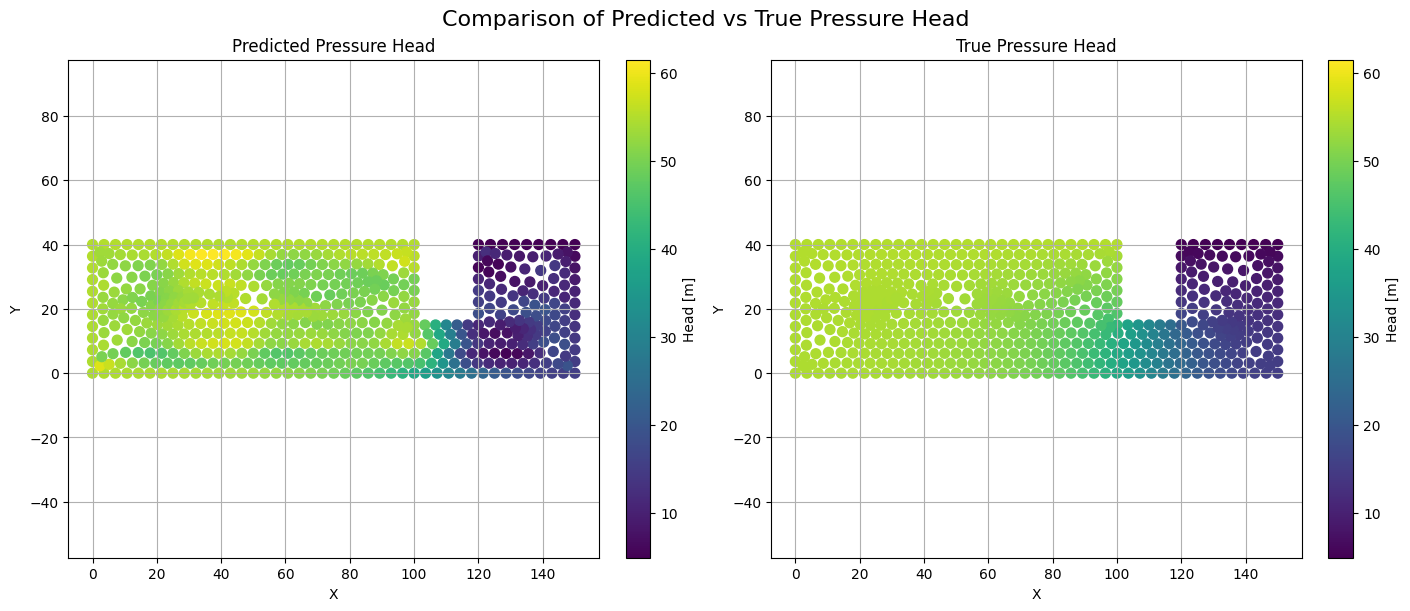

In [20]:
# --- Final prediction and visualization ---
with torch.no_grad():
    h_pred_tensor = model(xy_all).detach()
    h_pred = h_pred_tensor.cpu().numpy().squeeze() * h_max

r2 = r2_score(h_raw, h_pred)
print(f"\n Final R² Score: {r2:.5f}")

# Shared color limits
vmin = min(h_pred.min(), h_raw.min())
vmax = max(h_pred.max(), h_raw.max())

fig, axs = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

sc0 = axs[0].scatter(x_raw, y_raw, c=h_pred, cmap="viridis", edgecolors="face", s=50, vmin=vmin, vmax=vmax)
axs[0].set_title("Predicted Pressure Head")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].axis("equal")
axs[0].grid(True)
fig.colorbar(sc0, ax=axs[0], label="Head [m]")

sc1 = axs[1].scatter(x_raw, y_raw, c=h_raw, cmap="viridis", edgecolors="face", s=50, vmin=vmin, vmax=vmax)
axs[1].set_title("True Pressure Head")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].axis("equal")
axs[1].grid(True)
fig.colorbar(sc1, ax=axs[1], label="Head [m]")

plt.suptitle("Comparison of Predicted vs True Pressure Head", fontsize=16)
plt.show()

## 11 Velocity Plot

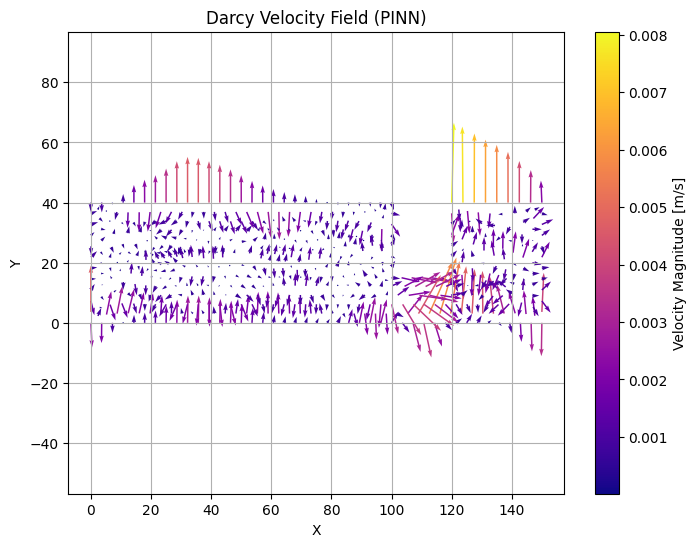

In [19]:

mag = np.sqrt(vx**2 + vy**2)
plt.figure(figsize=(8, 6))
q = plt.quiver(x_raw, y_raw, vx, vy, mag, cmap="plasma", scale=5e-2, width=0.003)
plt.colorbar(q, label="Velocity Magnitude [m/s]")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.grid(True)
plt.title("Darcy Velocity Field (PINN)")
plt.show()


## 12 Darcy Velocity and Flow Rate

In [21]:
kf = 1e-3
xy_raw.requires_grad_(True)
xy_for_grad = add_fourier_features(xy_raw)
h_pred_scaled = model(xy_for_grad)
grad = torch.autograd.grad(h_pred_scaled, xy_raw, torch.ones_like(h_pred_scaled), create_graph=True)[0]

hx = grad[:, 0] * (h_max / (x_max - x_min))
hy = grad[:, 1] * (h_max / (y_max - y_min))
vx = (-kf * hx).detach().cpu().numpy()
vy = (-kf * hy).detach().cpu().numpy()

bottom_idx = np.where(np.isclose(y_raw, y_min))[0]
vx_bottom = vx[bottom_idx]
x_bottom = x_raw[bottom_idx]
dx = np.diff(np.unique(x_bottom)).mean()
Q_pinn = np.sum(vx_bottom) * dx

L = 100.0
embedment_depth = 25.0
aquifer_depth = 40.0
A = (aquifer_depth - embedment_depth)
Q_analytical = kf * (h1 - h2) / L * A

print(f"\n PINN Flow Rate under dam: Q ≈ {Q_pinn:.4f} m³/s")
print(f" Analytical Darcy Flow: Q ≈ {Q_analytical:.4f} m³/s")


 PINN Flow Rate under dam: Q ≈ 0.0394 m³/s
 Analytical Darcy Flow: Q ≈ 0.0075 m³/s
